## Quadratically Constrained Quadratic Problem

We want to solve the following Quadratically Constrained Quadratic Problem (QCQP):

$P: \text{min}_X\; 0.5\cdot\mathbb{E}[||X^T\mathbf{y}(t)||^2]-\text{trace}(X^TB)$
$\text{s.t. } \text{trace}(X^TX)\leq \alpha^2,$ $X^T\mathbf{c}=\mathbf{d},$

in a distributed setting using the distributed adaptive signal fusion (DASF) framework.

In [2]:
import numpy as np
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
sys.path.append('../dasf_toolbox/')
import qcqp_functions as qcqp
from dasf_toolbox import dasf
from dasf_toolbox import dasf_block

rng = np.random.default_rng()

The network on which the QCQP will be solved is created randomly,
and has 10 nodes and 5 channels/sensors per node.

In [3]:
# Number of nodes.
nbnodes = 10
# Number of channels per node.
nbsensors_vec = 5 * np.ones(nbnodes)
nbsensors_vec = nbsensors_vec.astype(int)
# Number of channels in total.
nbsensors = np.sum(nbsensors_vec)
# Create adjacency matrix (hollow matrix) of a random graph.
graph_adj = rng.integers(0, 1, size=(nbnodes, nbnodes), endpoint=True)
graph_adj = np.triu(graph_adj, 1) + np.tril(graph_adj.T, -1)

The adjacency matrix of the network is:

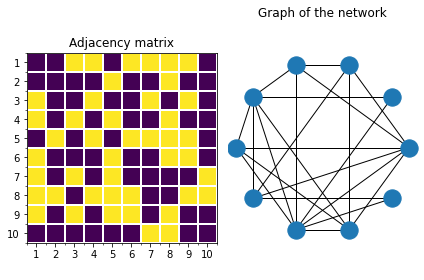

In [4]:
%matplotlib inline

fig, ax = plt.subplots(1, 2)
ax[0].imshow(graph_adj)
ax[0].set_xticks(np.arange(0, nbnodes, 1))
ax[0].set_yticks(np.arange(0, nbnodes, 1))
ax[0].set_xticklabels(np.arange(1, nbnodes + 1, 1))
ax[0].set_yticklabels(np.arange(1, nbnodes + 1, 1))
ax[0].set_xticks(np.arange(-.5, nbnodes, 1), minor=True)
ax[0].set_yticks(np.arange(-.5, nbnodes, 1), minor=True)
ax[0].grid(which='minor', color='w', linestyle='-', linewidth=2)
ax[0].set_title('Adjacency matrix')

graph = nx.from_numpy_array(graph_adj)
nx.draw_circular(graph)
ax[1].set_title('Graph of the network')
ax[1].axis('equal')

plt.tight_layout()
plt.show()


We now create the multi-channel signal $\mathbf{y}$ measured at the nodes,
the linear parameters $B$ and $\mathbf{c}$ and the global constants $\alpha$ and $\mathbf{d}$.
Each node measures blocks of 10000 samples to estimate the correlation matrices.
We choose the number of filters $Q$ (i.e., the number of columns of
$X$) to be equal to 3.

We make sure that:

$\alpha^2\geq||\mathbf{d}||^2/||\mathbf{c}||^2$,

which would guarantee that the problem is feasible.

In [5]:
# Number of filters of X.
Q = 3

# Number of samples of the signals.
nbsamples = 10000

Y, B, alpha, c, d = qcqp.create_data(nbsensors, nbsamples, Q)

The matrix `Y` contains in its columns time samples of $\mathbf{y}$:
$Y = [\mathbf{y}(1);\dots;\mathbf{y}(10000)]$.

When solving the QCQP in the DASF setting, we need to use a centralized solver to
solve the local problems created at each different node, where each node solves a parameterized
version of the original problem. The solver we use is `qcqp_solver` which solves:

$\text{min}_X\; 0.5\cdot\mathbb{E}[||X^T\mathbf{y}_1(t)||^2]-\text{trace}(X^TB_1)$
$\text{s.t. } \text{trace}(X^T\Gamma_1X)\leq g_1^2,$ $X^T\mathbf{b}_2=\mathbf{g}_2.$

Comparing it with problem $P$, we see that we have $\mathbf{y}_1=\mathbf{y}$,
$B_1=B$, $\mathbf{b}_2=\mathbf{c}$, $\Gamma_1=I$, $g_1=\alpha$ and $\mathbf{g}_2=\mathbf{d}$.

The data of the problem are stored in the dictionary `data` (see documentation for
more information).

In [6]:
Y_list = [Y]
B_list = [B, c]
Gamma_list = [np.identity(nbsensors)]
Glob_Const_list = [alpha, d]

data = {'Y_list': Y_list, 'B_list': B_list,
        'Gamma_list': Gamma_list, 'Glob_Const_list': Glob_Const_list}


In the distributed setting, each node $q$ will solve a parameterized version of the problem $P$
given by:

$\text{min}_{\widetilde{X}_q}\; 0.5\cdot\mathbb{E}[||\widetilde{X}_q^TC_q^T\mathbf{y}(t)||^2]-\text{trace}(\widetilde{X}_q^TC_q^TB)$
$\text{s.t. } \text{trace}(\widetilde{X}_q^TC_q^TC_q\widetilde{X}_q)\leq \alpha^2,$ $\widetilde{X}_q^TC_q^T\mathbf{c}=\mathbf{d}.$

Therefore, in `qcqp_solver`, we take $\mathbf{y}_1=C_q^T\mathbf{y}$,
$B_1=C_q^TB$, $\mathbf{b}_2=C_q^T\mathbf{c}$, $\Gamma_1=C_q^TC_q$, $g_1=\alpha$ and $\mathbf{g}_2=\mathbf{d}$.

The parameters of the problem are stored in the dictionary `prob_params` (see documentation for
more information):

In [7]:
prob_params = {'nbnodes': nbnodes, 'nbsensors_vec': nbsensors_vec,
                   'nbsensors': nbsensors, 'Q': Q, 'nbsamples': nbsamples}

The optimal filter $X^*$ is estimated using the centralized solver `qcqp_solver` taking
as input the data and problem parameters previously defined:

In [8]:
X_star = qcqp.qcqp_solver(prob_params, data)
f_star = qcqp.qcqp_eval(X_star, data) # f(X_star)

For the distributed context, we take the previously created network, and choose a randomly
generated sequence as the updating path, i.e., the order in which the nodes take turns
in solving their local problem.

We also fix the number of iterations of the DASF algorithm to be equal to 150.

In [9]:
prob_params['graph_adj'] = graph_adj

update_path = rng.permutation(range(nbnodes))
prob_params['update_path'] = update_path

nbiter = 150
conv = {'nbiter': nbiter}

We also provide $X^*$ to compare the estimation we get from the DASF algorithm to the optimal
value.

In [10]:
prob_params['X_star'] = X_star
prob_params['compare_opt'] = True

Finally, the QCQP is solved in a distributed setting using the DASF framework:

In [11]:
X_est, norm_diff, norm_err, f_seq = dasf(prob_params, data, qcqp.qcqp_solver,
                                        conv, prob_eval=qcqp.qcqp_eval, prob_select_sol=None)

Let us look at the plot of the normalized error $\frac{||X^i-X^*||_F^2}{||X^*||_F^2}$:

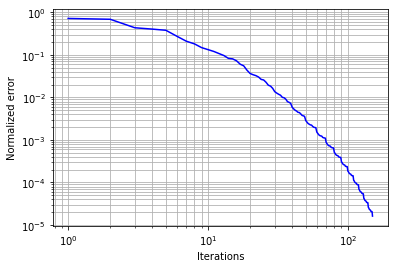

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.loglog(range(1, nbiter + 1), norm_err, color='b')
ax.set_xlabel('Iterations')
ax.set_ylabel('Normalized error')
ax.grid(True, which='both')
plt.show()